# Trabalho 4 - Restauração de Imagens

- **Disciplina:** SCC0251 - Processamento de Imagens 
- **Prof.** Moacir Antonelli Ponti
- **Autor:** Gabriel Van Loon Bode da Costa (10391607)
- **Data:** maio/2021

### Objetivo do Trabalho

Utilizar técnicas de restauração de imagens utilizando duas diferentes técnicas: *Adaptative Denoising Filter* e *Constrained Least Squares Filtering*. 

In [1]:
import imageio as img
import numpy as np
import random
import math
from scipy.fftpack import fftn, ifftn, fftshift
from scipy.fft import rfft2, irfft2 

### 1ª Etapa - Leitura dos Parâmetros

O programa recebe como entrada os parâmetros: o nome da imagem de referência (`f`), o nome da imagem degradada (`g`), o tipo de filtro a ser executado (`F = {1, 2}`), o valor do parâmetro usado nos filtros (γ = `P`) e outros parâmetros adicionais dependendo do método de filtragem escolhido.

In [5]:
# Caso de teste 1: f=polygons128.png  g=case1_10.png  F=1  P=0.15
# Caso de teste 2: f=polygons128.png  g=case2_45.png  F=1  P=0.95
# Caso de teste 3: f=moon_small.jpg   g=case3_70.png  F=1  P=0.80
# Caso de teste 4: f=moon_small.jpg   g=case3_70.png  F=1  P=1.00

f = input().rstrip()
g = input().rstrip()
F = int(input().rstrip())
P = float(input().rstrip())

imagens/case5_5_1.png


Filtro 1: Coordenadas do retângulo na imagem (`C`), tamanho do filtro (`N = {3,5,7,9,11}`) e modo (`M = {"robust", "average" }`)

Filtro 2: Tamanho do filtro gausiano (`k = {3,5,7,9,11}`) e std do filtro gausiano (`D`)

In [3]:
# Caso de teste 1: C=0 20 0 20  N=5  M=average
# Caso de teste 2: C=0 20 0 20  N=5  M=robust
# Caso de teste 3: C=0 20 0 20  N=3  M=robust
# Caso de teste 4: C=0 20 0 30  N=3  M=average

C = []
N = M = K = D = 0

if F == 1:
    C = np.array([int(x) for x in input().split()], dtype=int)
    N = int(input().rstrip())
    M = input().rstrip()
    
elif F == 2:
    K = int(input().rstrip())
    D = float(input().rstrip())

5
1.0


Por fim vamos deixar carregada a imagem de input a ser utilizada nas próximas etapas

In [6]:
reference_image = img.imread(f).astype(np.float32)
degraded_image  = img.imread(g).astype(np.float32)

### 2ª Etapa - Aplicando as Filtragems
 
- **Adaptative Denoising Filter** (opção 1)
- **Constrained Least Squares Filtering** (opção 2)

In [7]:
def _get_centrality_and_dispersion(crop, mode="average"):
    dispersion = centrality = None
    
    if mode == "average":
        centrality = np.mean(crop)
        dispersion = np.std(crop)
        
    elif mode == "robust":
        centrality = np.median(crop)
        dispersion = np.percentile(crop, [75])-np.percentile(crop,[25])
        
    return dispersion, centrality 
        
def adaptative_denoising_filter(image, cropped_image, filter_size=3, gamma=0.15, mode="average"):
    image  = image.copy()
    crop   = cropped_image.copy()
    output = np.zeros(image.shape, dtype=np.float32) 
    
    # Calc. estimated dispersion and centrality metrics from crop
    dispersion, centrality = _get_centrality_and_dispersion(crop)
    if dispersion == 0.0:
        dispersion = 1.0
    
    # Apply padding in image
    PADSIZE = int((filter_size-1)/2)
    image = np.pad(image, PADSIZE, mode="symmetric")
    
    # Apply 2D denoise filter
    for i in range(PADSIZE, image.shape[0]-PADSIZE):
        for j in range(PADSIZE, image.shape[1]-PADSIZE):
            
            g_ij = image[i,j]
            local_dispersion, local_centrality = _get_centrality_and_dispersion(image[i-PADSIZE:i+PADSIZE+1,j-PADSIZE:j+PADSIZE+1])
            
            if local_dispersion == 0.0:
                local_dispersion = dispersion
            
            output[i-PADSIZE,j-PADSIZE] = g_ij - gamma*(dispersion/local_dispersion)*(g_ij-local_centrality)
    
    return output

In [41]:
def gaussian_filter(k=3, sigma=1.0):
    arx  = np.arange((-k//2)+1.0, (k//2)+1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2)*(np.square(x) + np.square(y))/np.square(sigma))
    return filt/np.sum(filt)


def constrained_least_squares_filter(image, gamma=0.05, k=3, sigma=1.0):
    image  = image.copy()
    
    # Create the Gaussian Filter and pad to same size as the image
    gfilter = gaussian_filter(k, sigma)
    padsize = (image.shape[0]//2)-(k//2)
    gfilter = np.pad(gfilter, (padsize,padsize-1), "constant",  constant_values=0)
    
    # Create the Inverse Laplacian Filter 
    pfilter = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]],dtype=np.float32)
    padsize = (image.shape[0]//2)-(3//2)
    pfilter = np.pad(pfilter, (padsize,padsize-1), "constant",  constant_values=0)

    # Apply FFT in both image and gaussian filter
    G = rfft2(image)
    H = rfft2(gfilter)
    P = rfft2(pfilter)
    
    # Apply the CLS filter formula to generate F from G and H
    F = np.multiply(np.divide(np.conj(H), np.power(H,2) + gamma * np.power(P,2)), G)
    
    # Reverse f to the real domain from the frequency domain
    f = np.real(fftshift(irfft2(F)))
    return f

Com os filtros definidos, podemos agora aplicar a opção selecionada e obter a imagem de output

In [42]:
restored_image = None 

if F == 1:
    cropped_image  =  degraded_image[C[0]:C[1], C[2]:C[3]]
    restored_image = adaptative_denoising_filter(degraded_image, cropped_image, filter_size=N, gamma=P, mode=M)
elif F == 2:
    restored_image = constrained_least_squares_filter(degraded_image, gamma=P, k=K, sigma=D)

### 3ª Etapa - Climpando

Para evitar a criação de mais ruido, a imagem restaurada deve ser clipada ao invés de normalizada.

In [43]:
# output_image = output_image-np.min(output_image)
# output_image = output_image/np.max(output_image)
# output_image = output_image * 255.0

restored_image = np.clip(restored_image, 0.0, 255.0)

### 4ª Etapa - Comparando Entrada e Saída

In [44]:
reference_image  = reference_image.astype(np.float32)
restored_image   = restored_image.astype(np.float32)

# Calculating the error 
error =  np.sqrt(np.sum(np.power(reference_image-restored_image, 2.0))/restored_image.size)
print(format(error, ".4f"))

6.3190


### Etapa Extra - Visualizando as imagens geradas com a referência

(-0.5, 127.5, 127.5, -0.5)

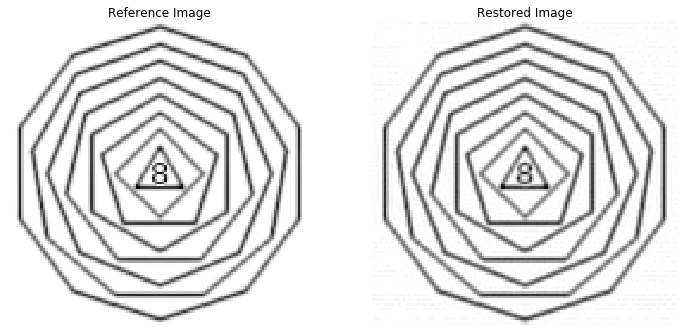

In [45]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,12)) 

# plt.subplot(121)
# plt.imshow(reference_image, cmap="gray", vmin=0, vmax=255)
# plt.title("Reference Image")
# plt.axis('off')

# plt.subplot(122)
# plt.imshow(restored_image, cmap="gray", vmin=0, vmax=255)
# plt.title("Restored Image")
# plt.axis('off')